## Post-Mortem Reflection

After some consideration, it seems as though this solution isn't 100% correct. Here's the biggest red flag:

Distributions done! Plots done! StatsPlots done! StatsBase done! Statistics done! 
Using threads: 4

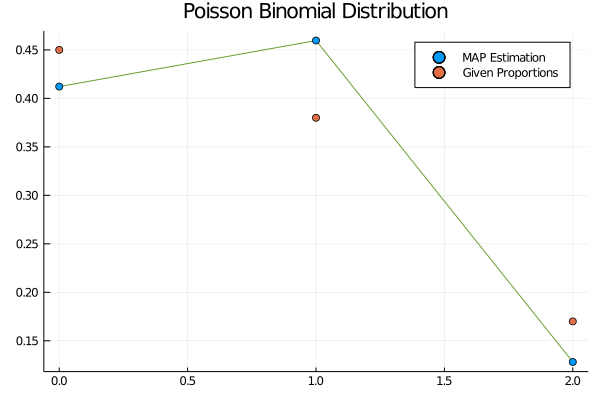

In [1]:
using Distributions
print("Distributions done! ")
using Plots
print("Plots done! ")
using StatsPlots
print("StatsPlots done! ")
using StatsBase
print("StatsBase done! ")
using Statistics
print("Statistics done! ")
print("\nUsing threads: ", Threads.nthreads())

data = [0.45,0.38,0.17]
plot(PoissonBinomial([0.358, 0.358]),
    title="Poisson Binomial Distribution",
    legend=true,
    label="MAP Estimation")
scatter!([0,1,2], data, label="Given Proportions")

The given proportions in the problem aren't anywhere close to the Poisson Binomial distribution using the maximum likelihood $p_i$ values. Whoops. This should be causing alarm bells that I previously missed and caused me to backtrack and think some more about this problem. Like I mentioned elsewhere, these are new tools and analysis approaches that I'm currently developing, so I'm taking this as a learning experience.

### Revisiting the Analysis

This estimation  100% correct though - it's ignoring the fact that the two covary and just picking the most probable values. In order to appropriately perform this, I'll reimplement the model quickly, then using posterior samples for the $p_i$ values, I'll generate new realizations of the data.

The following two code blocks are copied from the other notebook, just generating data and fitting the model.

In [2]:
obs = 25000 # n_observations
p_sim = rand(obs) # random numbers between 0-1
p_bound0 = .45 # below is 0 case, above 1
p_bound1 = .45+.38; # below is 1 case, above is 2

# Re-Simulate
outcomes = []
for i in p_sim
    if i < p_bound0
        push!(outcomes, 0);
    elseif i >= p_bound0 && i < p_bound1
        push!(outcomes, 1);
    else
        push!(outcomes,2);
    end
end

In [3]:
using Turing
# Rerun the model
N = collect(1:length(outcomes))
y = outcomes
J = length(outcomes)

samples = 5000
chains = 4

@model signals(y, J) = begin
    # Parameters
    p_a ~ Uniform(0,1)
    p_b ~ Uniform(0,1)
    
    # Model
    for i in 1:J
        y[i] ~  PoissonBinomial([p_a, p_b])
    end
end

model = signals(y, length(outcomes))
chn = sample(model, NUTS(), MCMCThreads(), samples, chains, progress=true)

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/tburch/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/tburch/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Info: Found initial step size
│   ϵ = 0.025
└ @ Turing.Inference /Users/tburch/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/tburch/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/tburch/.julia/packages/AdvancedHMC/P9wqk

Object of type Chains, with data of type 4000×14×4 Array{Float64,3}

Iterations        = 1:4000
Thinning interval = 1
Chains            = 1, 2, 3, 4
Samples per chain = 4000
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, max_hamiltonian_energy_error, n_steps, nom_step_size, numerical_error, step_size, tree_depth
parameters        = p_a, p_b

2-element Array{ChainDataFrame,1}

Summary Statistics
  parameters    mean     std  naive_se    mcse        ess   r_hat
  ──────────  ──────  ──────  ────────  ──────  ─────────  ──────
         p_a  0.3580  0.0055    0.0000  0.0001  6305.2850  1.0000
         p_b  0.3578  0.0055    0.0000  0.0001  5906.6830  1.0001

Quantiles
  parameters    2.5%   25.0%   50.0%   75.0%   97.5%
  ──────────  ──────  ──────  ──────  ──────  ──────
         p_a  0.3471  0.3543  0.3581  0.3617  0.3687
         p_b  0.3471  0.3541  0.3578  0.3615  0.3688


### Simulating data

Our posterior has many different values of p_a and p_b that could realize our data. What we now want to figure out is how likely it is given p_i values that the data is realized. We can do this by simulating the using posterior draws of the $p$ values, and generating sets of observations equal to our original number of simulated observations.

In [9]:
eval_zeros, eval_ones, eval_twos = [],[],[]

posterior_evals = 4000 # How many parameter draws we will do
size_of_eval = obs # How many data points per posterior draw, same amount as data we have

for i in 1:posterior_evals
    
    # Pick which sample to use
    chain_to_sample = rand(1:chains)
    iter_to_sample = rand(1:samples-1000)
    
    # Draw the p_a and p_b values of that sample
    the_draw = get(chn,[:p_a,:p_b])    
    p_a_val = the_draw[:p_a][iter_to_sample, chain_to_sample]
    p_b_val = the_draw[:p_b][iter_to_sample, chain_to_sample] 
    
    # Randomly sample a PoissonBinomal size_of_eval times
    counts = countmap(rand(PoissonBinomial([p_a_val, p_b_val]), size_of_eval))
    
    # Normalize those values
    rate_counts = values(sort(counts)) ./ sum(values(counts)) #sorts dictionary to 0,1,2 normalizes
    
    # Save them to arrays
    push!(eval_zeros, rate_counts[1])
    push!(eval_ones, rate_counts[2])
    push!(eval_twos, rate_counts[3]);
end

Next, we take those new simulated observation sets and get our 1 and 2$\sigma$ bands, taking the inner 68% and 95% results

In [10]:
function one_two_sigma(arr)
    one_sigma =  quantile(arr, [0.16,0.84])
    two_sigma =  quantile(arr, [0.05,0.95])
    central = quantile(arr, 0.5)
    return(one_sigma, two_sigma, central)
end

zero_onesig, zero_twosig, zero_central = one_two_sigma(eval_zeros)
one_onesig, one_twosig, one_central = one_two_sigma(eval_ones)
two_onesig, two_twosig, two_central = one_two_sigma(eval_twos);

In [11]:
y = [zero_central, one_central, two_central]
lower_one = [zero_onesig[1], one_onesig[1], two_onesig[1]]
upper_one = [zero_onesig[2], one_onesig[2], two_onesig[2]]
lower_two = [zero_twosig[1], one_twosig[1], two_twosig[1]]
upper_two = [zero_twosig[2], one_twosig[2], two_twosig[2]];

Last, generate a plot that overlays our true data with the new simulated data using our posterior

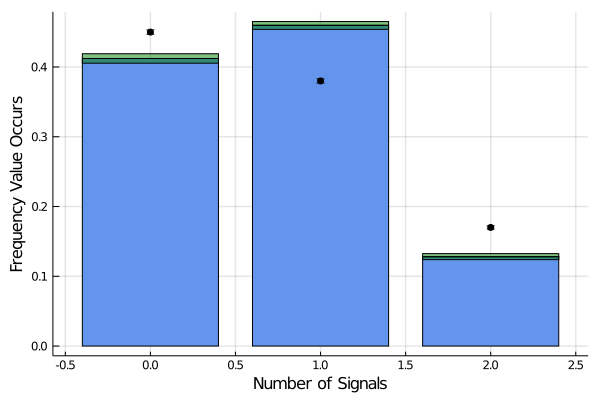

In [13]:
# Central Value
x=[0,1,2]
bar(x,y,c=:cornflowerblue, gridwidth=1.5, label="Central Predicted Value", legend=false)

#2σ
bar!(x,y, fillrange=lower_two, fillalpha=0.5, c=:green, legend=false, label="2σ")
bar!(x,y, fillrange=upper_two, fillalpha=0.5, c=:green, legend=false)


# Actual data
error = sqrt.(data .* (1 .- data) ./ obs) #poisson errors for proportions
scatter!(x,data, errorbar=error, c=:black,  xlab="Number of Signals", ylab="Frequency Value Occurs")

The blue histogram is the central expected value of our simulated data sets, the 2 $\sigma$ band is given in green shading. We can see that this data given, shown in black with Poisson errors, is _incredibly_ outside our domain of belief here. To parameterize in terms of standard deviations,

In [14]:
function eval_deviation(arr, data_val)
    return(round(abs(mean(arr)-data_val)/std(arr),digits=1))
end

println("0's number of deviations from mean: ", eval_deviation(eval_zeros, data[1]))
println("1's number of deviations from mean: ", eval_deviation(eval_ones, data[2]))
println("2's number of deviations from mean: ", eval_deviation(eval_twos, data[3]))


0's number of deviations from mean: 9.1
1's number of deviations from mean: 23.4
2's number of deviations from mean: 16.0


## Conclusion

Given this, I should cycle back to my answer. This model would need a 23.4$\sigma$ deviation in order to cover the data proportions we observe, this gives us incredible certainty that it isn't generating our data. Reminder that 5$\sigma$ equates to 99.99994% confidence, so 24$\sigma$ is effectively "not likely to happen by the inevitable heat death of the universe" territory.

If that's not convincing enough, you could further convince yourself by simulating more data, but I leave that as an exercise to the reader.